In [ ]:
!pip install nlpaug
!pip install ktrain
!pip install tensorflow
!pip install transformers

# Importing necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import nlpaug.augmenter.word as naw


# Mount Google Drive (only applicable in Google Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Load the dataset
path = 'drive/My Drive/Colab Notebooks/public-data/text_data'
df = pd.read_csv(path + '/public_data.csv')

# Function for basic text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

# Data preprocessing
df['text'] = df['text'].astype(str)
indexes_to_drop = df[df['label'].isin(['|', '11', '22', '32', '21'])].index
df.drop(indexes_to_drop, inplace=True)
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df.dropna(subset=['label'], inplace=True)
df['label'] = df['label'].astype('int32')
df = df.drop_duplicates(subset='text', keep='first')
df['text'] = df['text'].apply(clean_text)

# Augmentation function
def augment_text(df, augmenter, repetitions=1):
    aug_texts = []
    for _, row in df.iterrows():
        text = row['text']
        for _ in range(repetitions):
            augmented_text = augmenter.augment(text)
            aug_texts.append((augmented_text, row['label']))
    return pd.DataFrame(aug_texts, columns=['text', 'label'])

# Synonym Augmenter
augmenter = naw.SynonymAug(aug_src='wordnet')

# Upsampling using augmentation
max_size = df['label'].value_counts().max()
df_balanced = pd.DataFrame()
for label in df['label'].unique():
    df_class = df[df['label'] == label]
    df_class_aug = augment_text(df_class, augmenter, repetitions=max_size // len(df_class) - 1)
    df_balanced = pd.concat([df_balanced, df_class, df_class_aug])


# Print class distribution after augmentation
print("\nClass distribution after augmentation:")
print(df_balanced['label'].value_counts())


# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=123).reset_index(drop=True)



# Define class names
class_names = ['0', '1', '2', '3']

# Tokenizer from transformers
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Function to encode texts
def encode_texts(tokenizer, texts, max_length=256):
    input_ids = []
    attention_masks = []

    for text in texts:
        text = str(text)
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf',
        )

        input_ids.append(encoded['input_ids'][0])
        attention_masks.append(encoded['attention_mask'][0])

    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_masks)

# Splitting the data
X_train, X_temp, y_train, y_temp = train_test_split(df_balanced['text'], df_balanced['label'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Encoding the data
train_inputs, train_masks = encode_texts(tokenizer, X_train)
val_inputs, val_masks = encode_texts(tokenizer, X_val)
test_inputs, test_masks = encode_texts(tokenizer, X_test)

# Converting labels to tensors
train_labels = tf.convert_to_tensor(y_train.to_numpy().astype('int32'))
val_labels = tf.convert_to_tensor(y_val.to_numpy().astype('int32'))
test_labels = tf.convert_to_tensor(y_test.to_numpy().astype('int32'))

# Model initialization
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

# Model compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Model training with validation data and early stopping
history = model.fit(
    [train_inputs, train_masks],
    train_labels,
    batch_size=20,
    validation_data=([val_inputs, val_masks], val_labels),
    epochs=20,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([test_inputs, test_masks], test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Save the model
model.save_pretrained('/content/drive/My Drive/Colab Notebooks/public-data/models/distilbert-cyberbullying-classifier')

Mounted at /content/drive

Class distribution after augmentation:
label
0    4439
3    4418
1    4410
2    4368
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/20


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
706/706 [==============================] - 419s 519ms/step - loss: 0.2995 - accuracy: 0.8884 - val_loss: 0.0293 - val_accuracy: 0.9926
Epoch 2/20
706/706 [==============================] - 358s 507ms/step - loss: 0.0315 - accuracy: 0.9910 - val_loss: 0.0317 - val_accuracy: 0.9898
Epoch 3/20
706/706 [==============================] - 363s 514ms/step - loss: 0.0154 - accuracy: 0.9952 - val_loss: 0.0286 - val_accuracy: 0.9904
Epoch 4/20
706/706 [==============================] - 363s 515ms/step - loss: 0.0121 - accuracy: 0.9962 - val_loss: 0.0314 - val_accuracy: 0.9915
Epoch 5/20
706/706 [==============================] - 363s 515ms/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.0304 - val_accuracy: 0.9921
Epoch 6/20
56/56 [==============================] - 15s 265ms/step - loss: 0.0336 - accuracy: 0.9909
Test Loss: 0.033624302595853806
Test Accur

56/56 [==============================] - 24s 280ms/step
Confusion Matrix:
[[424   0   3   1]
 [  9 453   0   0]
 [  1   0 434   0]
 [  2   0   0 437]]
Precision: 0.9910610149423653
Recall: 0.9909297052154195
F1 Score: 0.9909482361443722


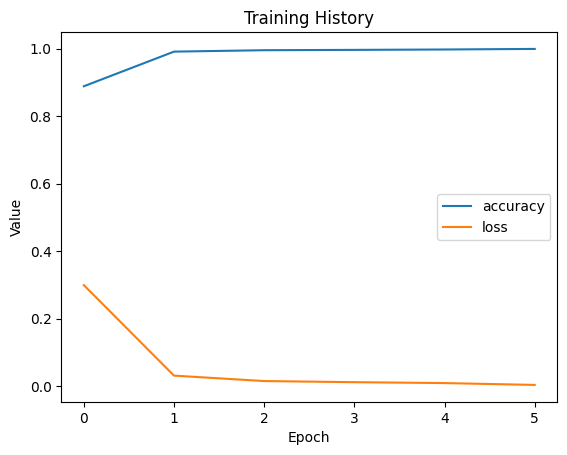

In [ ]:

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt


# Evaluate the model on the test set
predictions = model.predict([test_inputs, test_masks])[0]
predicted_classes = np.argmax(predictions, axis=1)


y_test_np = np.array(y_test).astype('int32')


cm = confusion_matrix(y_test_np, predicted_classes)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_np, predicted_classes, average='weighted')

print(f'Confusion Matrix:\n{cm}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}')

# Plotting training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend()
plt.show()



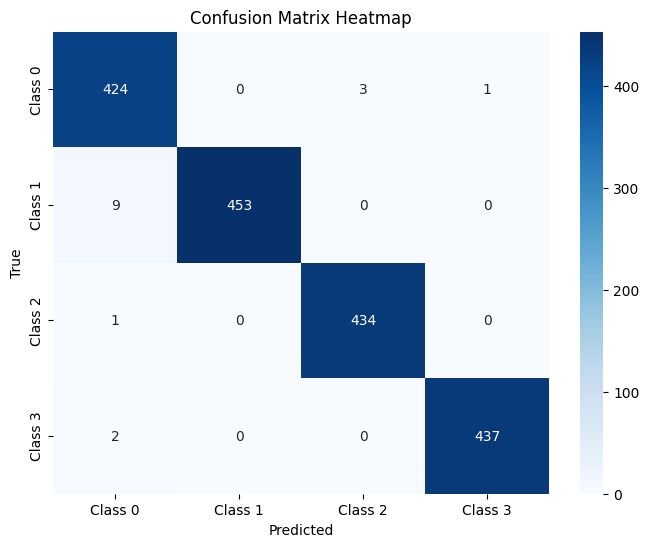

In [ ]:
y_test_np = np.array(y_test).astype('int32')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Calculate confusion matrix
cm = confusion_matrix(y_test_np, predicted_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


56/56 [==============================] - 16s 281ms/step
Metrics for Class 0:
Precision: 0.9724770642201835
Recall: 0.9906542056074766
F1 Score: 0.9814814814814815
Accuracy: 0.9909297052154195



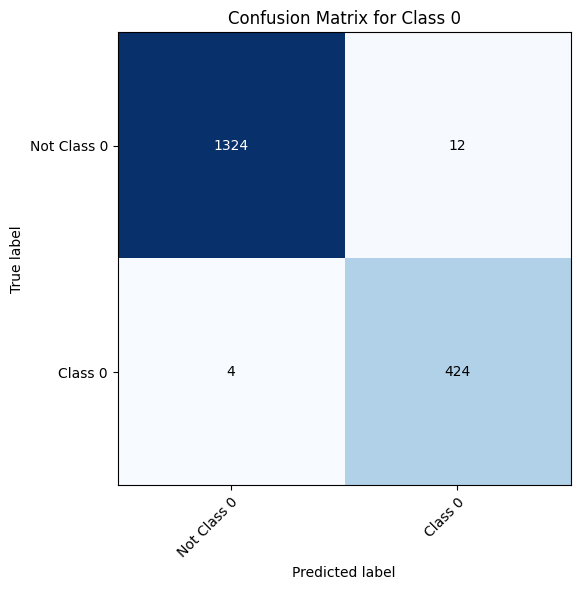

Metrics for Class 1:
Precision: 1.0
Recall: 0.9805194805194806
F1 Score: 0.9901639344262295
Accuracy: 0.9948979591836735



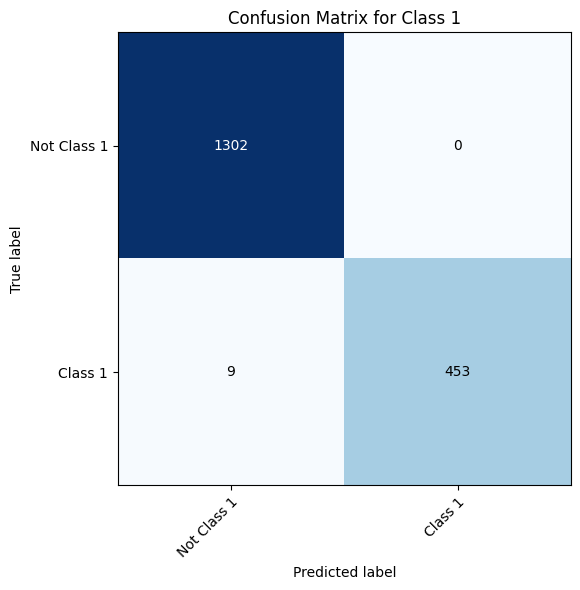

Metrics for Class 2:
Precision: 0.9931350114416476
Recall: 0.9977011494252873
F1 Score: 0.9954128440366972
Accuracy: 0.9977324263038548



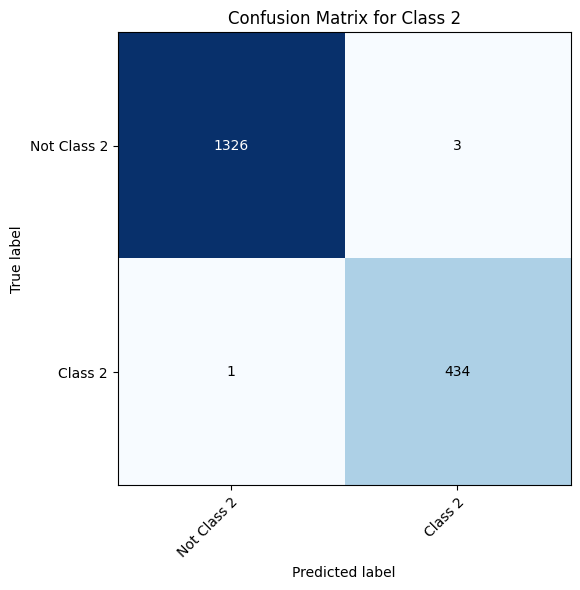

Metrics for Class 3:
Precision: 0.997716894977169
Recall: 0.9954441913439636
F1 Score: 0.9965792474344355
Accuracy: 0.9982993197278912



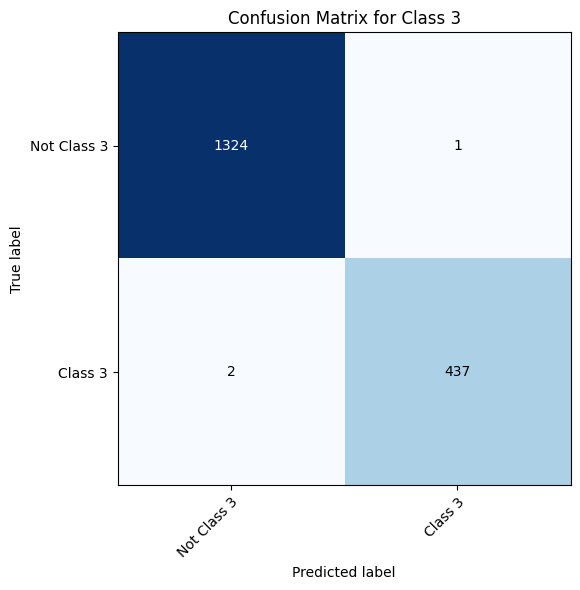

In [ ]:
# Predictions
test_predictions = model.predict([test_inputs, test_masks])
test_predictions = np.argmax(test_predictions.logits, axis=1)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_index, class_names):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set(xticks=np.arange(2),
           yticks=np.arange(2),
           xticklabels=[f'Not Class {class_index}', f'Class {class_index}'],
           yticklabels=[f'Not Class {class_index}', f'Class {class_index}'],
           title=f'Confusion Matrix for Class {class_names[class_index]}',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

# Display metrics and confusion matrix for each class
for class_index in range(len(class_names)):
    true_binary = (y_test == class_index)
    pred_binary = (test_predictions == class_index)
    conf_matrix = confusion_matrix(true_binary, pred_binary, labels=[False, True])

    precision, recall, f1, _ = precision_recall_fscore_support(true_binary, pred_binary, labels=[False, True])

    # Calculate accuracy
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

    print(f"Metrics for Class {class_index}:")
    print(f"Precision: {precision[1]}")
    print(f"Recall: {recall[1]}")
    print(f"F1 Score: {f1[1]}")
    print(f"Accuracy: {accuracy}\n")

    plot_confusion_matrix(conf_matrix, class_index, class_names)




# **ROC-AUC**

56/56 [==============================] - 16s 277ms/step


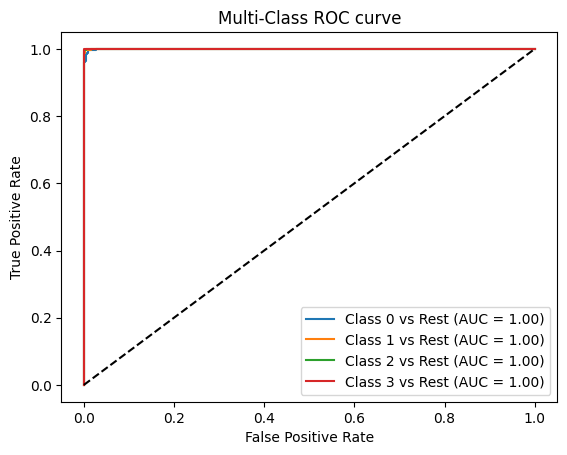

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Predict probabilities
pred_probabilities = model.predict([test_inputs, test_masks])
preds = tf.nn.softmax(pred_probabilities.logits).numpy()

# For multi-class, calculate ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()
n_class = len(class_names)

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(to_categorical(y_test, num_classes=n_class)[:,i], preds[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle='-', label=f'Class {i} vs Rest (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC curve')
plt.legend(loc='best')
plt.show()
